# Predicting All-Star Status of MLB Pitchers

## Notebook Setup

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import scipy.stats
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV
import warnings

In [2]:
warnings.filterwarnings('ignore')
np.random.seed(seed = 42)

# MLB Pitching Data: Pre-processing and cleaning

In [3]:
pitching = pd.read_csv('data/core/Pitching.csv')
pitching = pitching[pitching['yearID'] > 1984]
pitching = pitching[pitching['yearID'] < 2020]
pitching = pitching[pitching['yearID'] != 1994]
pitching

,playerID,yearID,stint,teamID,lgID,W,L,G,GS,CG,...,IBB,WP,HBP,BK,BFP,GF,R,SH,SF,GIDP
24984,aasedo01,1985,1,BAL,AL,10,6,54,0,0,...,7.0,0,1.0,1,366.0,43,44,5.0,3.0,13.0
24985,abregjo01,1985,1,CHN,NL,1,1,6,5,0,...,1.0,0,0.0,0,109.0,0,18,5.0,1.0,3.0
24986,ackerji01,1985,1,TOR,AL,7,2,61,0,0,...,1.0,2,3.0,0,370.0,26,35,1.0,2.0,16.0
24987,agostju01,1985,1,CHA,AL,4,3,54,0,0,...,1.0,0,3.0,0,246.0,21,27,3.0,3.0,4.0
24988,aguilri01,1985,1,NYN,NL,10,7,21,19,2,...,2.0,5,2.0,2,507.0,1,49,7.0,4.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47624,zamorda01,2019,1,NYN,NL,0,1,17,0,0,...,1.0,0,1.0,0,41.0,3,5,0.0,1.0,0.0
47625,zeuchtj01,2019,1,TOR,AL,1,2,5,3,0,...,0.0,2,0.0,0,99.0,0,13,0.0,0.0,1.0
47626,zimmejo02,2019,1,DET,AL,1,13,23,23,0,...,2.0,3,6.0,0,504.0,0,89,3.0,4.0,5.0
47627,zimmeky01,2019,1,KCA,AL,0,1,15,0,0,...,0.0,2,0.0,0,102.0,3,22,0.0,0.0,1.0


# MLB All-Star Data from 1985-2019, excluding 1994, a walk-out year 

In [4]:
all_star_full = pd.read_csv('data/core/AllstarFull.csv')
all_star_full = all_star_full[all_star_full['yearID'] > 1984]
all_star_full = all_star_full[all_star_full['yearID'] < 2020]
all_star_full = all_star_full[all_star_full['yearID'] != 1994]
all_star_full

,playerID,yearID,gameNum,gameID,teamID,lgID,GP,startingPos
3035,morrija02,1985.0,0.0,ALS198507160,DET,AL,1,1.0
3036,fiskca01,1985.0,0.0,ALS198507160,CHA,AL,1,2.0
3037,murraed02,1985.0,0.0,ALS198507160,BAL,AL,1,3.0
3038,whitalo01,1985.0,0.0,ALS198507160,DET,AL,1,4.0
3039,brettge01,1985.0,0.0,ALS198507160,KCA,AL,1,5.0
...,...,...,...,...,...,...,...,...
5369,smithwi04,2019.0,0.0,ALS201907090,SFN,NL,1,NaN
5370,sorokmi01,2019.0,0.0,ALS201907090,ATL,NL,1,NaN
5371,storytr01,2019.0,0.0,ALS201907090,COL,NL,1,NaN
5372,woodrbr01,2019.0,0.0,ALS201907090,MIL,NL,1,NaN


### Aggregating all-star data to pitching data

In [5]:
is_all_star = list()
for i in range(len(pitching)):
    pitcher = pitching.iloc[i, :]
    pitcher_name = pitcher['playerID']
    year = pitcher['yearID']
    
    all_star = all_star_full[all_star_full['yearID'] == year]
    all_star = all_star[all_star['playerID'] == pitcher_name]
    if(len(all_star) > 0):
        is_all_star.append(True)
    else:
        is_all_star.append(False)
#is_all_star

In [6]:
pitching['is_all_star'] = is_all_star
pitching

,playerID,yearID,stint,teamID,lgID,W,L,G,GS,CG,...,WP,HBP,BK,BFP,GF,R,SH,SF,GIDP,is_all_star
24984,aasedo01,1985,1,BAL,AL,10,6,54,0,0,...,0,1.0,1,366.0,43,44,5.0,3.0,13.0,False
24985,abregjo01,1985,1,CHN,NL,1,1,6,5,0,...,0,0.0,0,109.0,0,18,5.0,1.0,3.0,False
24986,ackerji01,1985,1,TOR,AL,7,2,61,0,0,...,2,3.0,0,370.0,26,35,1.0,2.0,16.0,False
24987,agostju01,1985,1,CHA,AL,4,3,54,0,0,...,0,3.0,0,246.0,21,27,3.0,3.0,4.0,False
24988,aguilri01,1985,1,NYN,NL,10,7,21,19,2,...,5,2.0,2,507.0,1,49,7.0,4.0,8.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47624,zamorda01,2019,1,NYN,NL,0,1,17,0,0,...,0,1.0,0,41.0,3,5,0.0,1.0,0.0,False
47625,zeuchtj01,2019,1,TOR,AL,1,2,5,3,0,...,2,0.0,0,99.0,0,13,0.0,0.0,1.0,False
47626,zimmejo02,2019,1,DET,AL,1,13,23,23,0,...,3,6.0,0,504.0,0,89,3.0,4.0,5.0,False
47627,zimmeky01,2019,1,KCA,AL,0,1,15,0,0,...,2,0.0,0,102.0,3,22,0.0,0.0,1.0,False


## Splitting data to ensure equal distribution of all-stars and non-all-stars.
#### *Useful for maintaining precision*

In [7]:
pitching_all_stars = pitching[pitching['is_all_star'] == True]
pitching_not_all_stars_sample = pitching[pitching['is_all_star'] == False].sample(len(pitching_all_stars))
pitching = pd.concat([pitching_all_stars, pitching_not_all_stars_sample])
pitching

,playerID,yearID,stint,teamID,lgID,W,L,G,GS,CG,...,WP,HBP,BK,BFP,GF,R,SH,SF,GIDP,is_all_star
24993,andujjo01,1985,1,SLN,NL,21,12,38,38,10,...,2,11.0,0,1127.0,0,113,11.0,4.0,32.0,True
25016,blylebe01,1985,1,CLE,AL,9,11,23,23,15,...,1,7.0,1,743.0,0,76,4.0,4.0,11.0,True
25017,blylebe01,1985,2,MIN,AL,8,5,14,14,9,...,3,2.0,0,460.0,0,45,1.0,4.0,10.0,True
25070,darliro01,1985,1,NYN,NL,16,6,36,35,4,...,7,3.0,1,1043.0,1,93,13.0,4.0,23.0,True
25113,garresc01,1985,1,SFN,NL,9,6,74,0,0,...,7,3.0,1,454.0,44,37,6.0,3.0,6.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39168,davidda02,2009,1,LAA,AL,0,0,4,0,0,...,0,0.0,0,11.0,1,1,0.0,0.0,0.0,False
42846,grayso01,2014,1,OAK,AL,14,10,33,33,2,...,15,7.0,0,899.0,0,84,8.0,5.0,21.0,False
25992,easteja01,1987,1,CLE,AL,1,1,16,0,0,...,5,1.0,0,137.0,1,17,2.0,2.0,1.0,False
27619,montgje01,1990,1,KCA,AL,6,5,73,0,0,...,3,5.0,0,400.0,59,36,2.0,2.0,2.0,False


In [8]:
pitching.columns

Index(['playerID', 'yearID', 'stint', 'teamID', 'lgID', 'W', 'L', 'G', 'GS',
       'CG', 'SHO', 'SV', 'IPouts', 'H', 'ER', 'HR', 'BB', 'SO', 'BAOpp',
       'ERA', 'IBB', 'WP', 'HBP', 'BK', 'BFP', 'GF', 'R', 'SH', 'SF', 'GIDP',
       'is_all_star'],
      dtype='object')

# Column Selection - Relevant Pitching Statistics

In [9]:
pitching = pitching.drop(columns = ['stint', 'lgID', 'W', 'L', 'G', 'GS', 'CG', 'SV', 'IPouts', 'IBB', 'BK', 'BFP', 'GF', 'SH', 'SF'])
pitching

,playerID,yearID,teamID,SHO,H,ER,HR,BB,SO,BAOpp,ERA,WP,HBP,R,GIDP,is_all_star
24993,andujjo01,1985,SLN,2,265,102,15,82,112,0.260,3.40,2,11.0,113,32.0,True
25016,blylebe01,1985,CLE,4,163,65,14,49,129,0.240,3.26,1,7.0,76,11.0,True
25017,blylebe01,1985,MIN,1,101,38,9,26,77,0.237,3.00,3,2.0,45,10.0,True
25070,darliro01,1985,NYN,2,214,80,21,114,167,0.235,2.90,7,3.0,93,23.0,True
25113,garresc01,1985,SFN,0,76,27,2,58,106,0.198,2.30,7,3.0,37,6.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39168,davidda02,2009,LAA,0,3,1,0,3,0,0.375,5.40,0,0.0,1,0.0,False
42846,grayso01,2014,OAK,2,187,75,15,74,183,0.232,3.08,15,7.0,84,21.0,False
25992,easteja01,1987,CLE,0,26,16,4,13,22,0.218,4.55,5,1.0,17,1.0,False
27619,montgje01,1990,KCA,0,81,25,6,34,94,0.228,2.39,3,5.0,36,2.0,False


In [10]:
pitching = pitching.dropna()
pitching.loc[:,"is_all_star"] = pitching["is_all_star"].astype(int)
#pitching['is_all_star']

# EDA: Boxplot Visualization for All-star vs. non All-star

BAOpp         AxesSubplot(0.1,0.15;0.056338x0.75)
BB       AxesSubplot(0.167606,0.15;0.056338x0.75)
ER       AxesSubplot(0.235211,0.15;0.056338x0.75)
ERA      AxesSubplot(0.302817,0.15;0.056338x0.75)
GIDP     AxesSubplot(0.370423,0.15;0.056338x0.75)
H        AxesSubplot(0.438028,0.15;0.056338x0.75)
HBP      AxesSubplot(0.505634,0.15;0.056338x0.75)
HR       AxesSubplot(0.573239,0.15;0.056338x0.75)
R        AxesSubplot(0.640845,0.15;0.056338x0.75)
SHO      AxesSubplot(0.708451,0.15;0.056338x0.75)
SO       AxesSubplot(0.776056,0.15;0.056338x0.75)
WP       AxesSubplot(0.843662,0.15;0.056338x0.75)
dtype: object

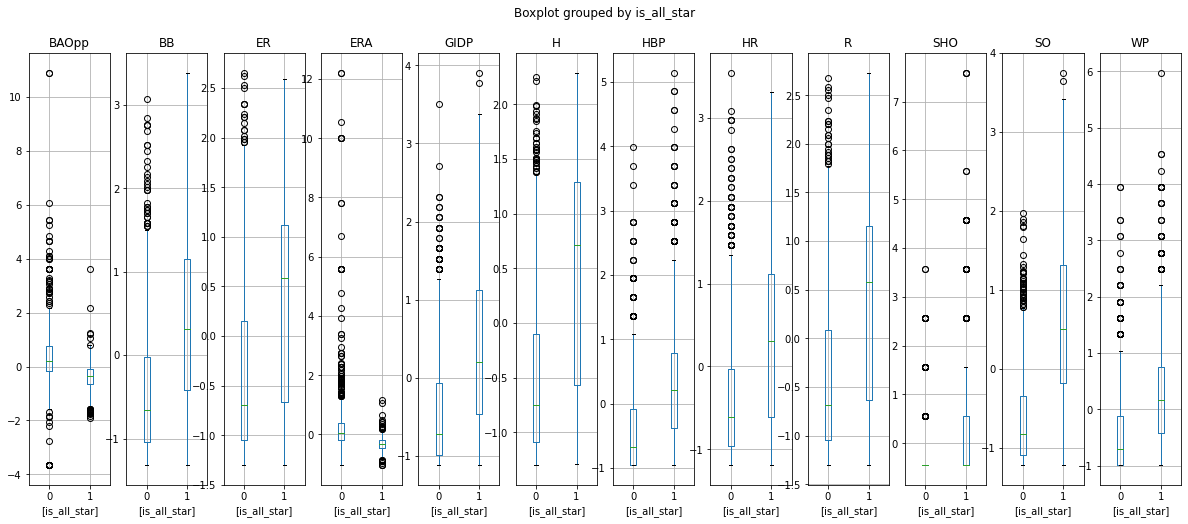

In [11]:
pitching_boxplots = pitching.copy()

pitching_boxplots_is_all_star = pitching_boxplots['is_all_star']

pitching_boxplots.drop(columns = ['is_all_star', 'yearID', 'playerID', 'teamID'], inplace = True)

pitching_boxplots = (pitching_boxplots - pitching_boxplots.mean()) / pitching_boxplots.std()

pitching_boxplots['is_all_star'] = pitching_boxplots_is_all_star

fig, axes = plt.subplots(ncols = 12, figsize = (20, 8))
pitching_boxplots.query("is_all_star in [0, 1]").boxplot(by='is_all_star', return_type = 'axes', ax = axes)


# EDA: Visualization for Relevant Variable Correlations

In [12]:
pitching_boxplots.corr().style.background_gradient().format(precision = 2)

,SHO,H,ER,HR,BB,SO,BAOpp,ERA,WP,HBP,R,GIDP,is_all_star
SHO,1.00,0.56,0.48,0.39,0.48,0.56,-0.11,-0.13,0.31,0.35,0.48,0.50,0.33
H,0.56,1.00,0.96,0.87,0.85,0.82,-0.11,-0.21,0.55,0.63,0.97,0.87,0.45
ER,0.48,0.96,1.00,0.91,0.87,0.75,-0.05,-0.13,0.55,0.63,1.00,0.82,0.34
HR,0.39,0.87,0.91,1.00,0.75,0.74,-0.10,-0.14,0.47,0.57,0.90,0.70,0.34
BB,0.48,0.85,0.87,0.75,1.00,0.77,-0.19,-0.21,0.65,0.63,0.87,0.77,0.40
SO,0.56,0.82,0.75,0.74,0.77,1.00,-0.33,-0.29,0.60,0.62,0.76,0.67,0.61
BAOpp,-0.11,-0.11,-0.05,-0.10,-0.19,-0.33,1.00,0.72,-0.19,-0.14,-0.06,-0.11,-0.38
ERA,-0.13,-0.21,-0.13,-0.14,-0.21,-0.29,0.72,1.00,-0.17,-0.15,-0.14,-0.21,-0.33
WP,0.31,0.55,0.55,0.47,0.65,0.60,-0.19,-0.17,1.00,0.41,0.56,0.46,0.34
HBP,0.35,0.63,0.63,0.57,0.63,0.62,-0.14,-0.15,0.41,1.00,0.64,0.58,0.33


# Splitting Data for Training and Testing

In [13]:
train, test = train_test_split(pitching, random_state = 42)

X_train = train.drop(columns = ['playerID', 'yearID', 'teamID', 'is_all_star'])
y_train = train['is_all_star']

X_test = test.drop(columns = ['playerID', 'yearID', 'teamID', 'is_all_star'])
y_test = test['is_all_star']

# Modeling - Random Forest

In [14]:
forest_model = RandomForestClassifier(random_state = 42, n_jobs = 1)
fitted = forest_model.fit(X_train, y_train)
rf_predictions_test = fitted.predict(X_test)
rf_predictions_train = fitted.predict(X_train)

# Training and Test Accuracy for Initial Random Forest Model

In [15]:
print('training accuracy for random forest: ')
np.mean(y_train == rf_predictions_train)

training accuracy for random forest: 


1.0

In [16]:
print('test accuracy for random forest: ')
np.mean(y_test == rf_predictions_test)

test accuracy for random forest: 


0.8348623853211009

# Validation for Initial Random Forest Model

In [17]:
confusion_matrix_rf = metrics.confusion_matrix(y_test, rf_predictions_test, normalize = 'all')
precision_rf = confusion_matrix_rf[1][1] / (confusion_matrix_rf[1][1] + confusion_matrix_rf[0][1])
recall_rf = confusion_matrix_rf[1][1] / (confusion_matrix_rf[1][1] + confusion_matrix_rf[1][0])
print('precision: ' + str(precision_rf))
print('recall: ' + str(recall_rf))

precision: 0.8174273858921163
recall: 0.8755555555555556


In [18]:
rf_fpr, rf_tpr, rf_thresholds = metrics.roc_curve(y_test, rf_predictions_test)
rf_fpr, rf_tpr, rf_thresholds

(array([0.        , 0.20853081, 1.        ]),
 array([0.        , 0.87555556, 1.        ]),
 array([2, 1, 0]))

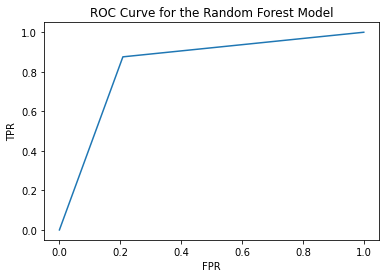

In [19]:
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve for the Random Forest Model')
plt.plot(rf_fpr, rf_tpr)

# Modeling - Logistic Regression

In [20]:
lr_model = LogisticRegression(random_state = 42, max_iter = 2000, n_jobs = 1)
fitted = lr_model.fit(X_train, y_train)
lr_predictions_test = fitted.predict(X_test)
lr_predictions_train = fitted.predict(X_train)

# Training and Test Accuracy for Initial Logistic Regression Model

In [21]:
print('training accuracy for logistic regression: ')
np.mean(y_train == lr_predictions_train)

training accuracy for logistic regression: 


0.854628921193573

In [22]:
print('test accuracy for logistic regression: ')
np.mean(y_test == lr_predictions_test)

test accuracy for logistic regression: 


0.8486238532110092

# Validation for Initial Logistic Regression Model

In [23]:
confusion_matrix_lr = metrics.confusion_matrix(y_test, lr_predictions_test, normalize = 'all')
precision_lr = confusion_matrix_lr[1][1] / (confusion_matrix_lr[1][1] + confusion_matrix_lr[0][1])
recall_lr = confusion_matrix_lr[1][1] / (confusion_matrix_lr[1][1] + confusion_matrix_lr[1][0])
print('precision: ' + str(precision_lr))
print('recall: ' + str(recall_lr))

precision: 0.8354430379746836
recall: 0.8800000000000001


In [24]:
lr_fpr, lr_tpr, lr_thresholds = metrics.roc_curve(y_test, lr_predictions_test)
lr_fpr, lr_tpr, lr_thresholds

(array([0.        , 0.18483412, 1.        ]),
 array([0.  , 0.88, 1.  ]),
 array([2, 1, 0]))

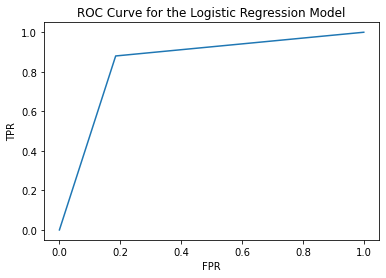

In [25]:
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve for the Logistic Regression Model')
plt.plot(lr_fpr, lr_tpr)

 # Optimization

# Random Search Optimization for Random Forest

In [26]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'random_state': [42],
               'n_jobs': [1]
              }

In [27]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 30, cv = 3, verbose=2, random_state=42, n_jobs = 1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV] random_state=42, n_jobs=1, n_estimators=200, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=50, bootstrap=True 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  random_state=42, n_jobs=1, n_estimators=200, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=50, bootstrap=True, total=   0.4s
[CV] random_state=42, n_jobs=1, n_estimators=200, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=50, bootstrap=True 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV]  random_state=42, n_jobs=1, n_estimators=200, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=50, bootstrap=True, total=   0.4s
[CV] random_state=42, n_jobs=1, n_estimators=200, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=50, bootstrap=True 
[CV]  random_state=42, n_jobs=1, n_estimators=200, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=50, bootstrap=True, total=   0.4s
[CV] random_state=42, n_jobs=1, n_estimators=600, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=90, bootstrap=False 
[CV]  random_state=42, n_jobs=1, n_estimators=600, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=90, bootstrap=False, total=   1.1s
[CV] random_state=42, n_jobs=1, n_estimators=600, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=90, bootstrap=False 
[CV]  random_state=42, n_jobs=1, n_estimators=600, min_samples_split=10, min_samples_leaf=4, max_features=

[CV]  random_state=42, n_jobs=1, n_estimators=2000, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=50, bootstrap=True, total=   3.8s
[CV] random_state=42, n_jobs=1, n_estimators=400, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=20, bootstrap=False 
[CV]  random_state=42, n_jobs=1, n_estimators=400, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=20, bootstrap=False, total=   0.8s
[CV] random_state=42, n_jobs=1, n_estimators=400, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=20, bootstrap=False 
[CV]  random_state=42, n_jobs=1, n_estimators=400, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=20, bootstrap=False, total=   0.7s
[CV] random_state=42, n_jobs=1, n_estimators=400, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=20, bootstrap=False 
[CV]  random_state=42, n_jobs=1, n_estimators=400, min_samples_split=10, min_samples_leaf=2, max_feature

[CV]  random_state=42, n_jobs=1, n_estimators=1600, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=None, bootstrap=True, total=   3.0s
[CV] random_state=42, n_jobs=1, n_estimators=1600, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=None, bootstrap=True 
[CV]  random_state=42, n_jobs=1, n_estimators=1600, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=None, bootstrap=True, total=   3.0s
[CV] random_state=42, n_jobs=1, n_estimators=1600, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=None, bootstrap=True 
[CV]  random_state=42, n_jobs=1, n_estimators=1600, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=None, bootstrap=True, total=   3.0s
[CV] random_state=42, n_jobs=1, n_estimators=1600, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=40, bootstrap=False 
[CV]  random_state=42, n_jobs=1, n_estimators=1600, min_samples_split=5, min_samples_leaf=2, max_f

[CV]  random_state=42, n_jobs=1, n_estimators=1800, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=90, bootstrap=True, total=   3.4s
[CV] random_state=42, n_jobs=1, n_estimators=1800, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=90, bootstrap=True 
[CV]  random_state=42, n_jobs=1, n_estimators=1800, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=90, bootstrap=True, total=   3.3s
[CV] random_state=42, n_jobs=1, n_estimators=600, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=60, bootstrap=False 
[CV]  random_state=42, n_jobs=1, n_estimators=600, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=60, bootstrap=False, total=   1.1s
[CV] random_state=42, n_jobs=1, n_estimators=600, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=60, bootstrap=False 
[CV]  random_state=42, n_jobs=1, n_estimators=600, min_samples_split=10, min_samples_leaf=2, max_featur

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:  3.6min finished


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=30,
                   n_jobs=1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000],
                                        'n_jobs': [1], 'random_state': [42]},
                   random_state=42, verbose=2)

In [28]:
rf_best_params = rf_random.best_params_
rf_best_params

{'random_state': 42,
 'n_jobs': 1,
 'n_estimators': 200,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 50,
 'bootstrap': True}

# Random Forest Model Training with Tuned Hyperparameters

In [29]:
forest_model = RandomForestClassifier(n_estimators = rf_best_params['n_estimators'], 
                                      min_samples_split = rf_best_params['min_samples_split'], 
                                      min_samples_leaf = rf_best_params['min_samples_leaf'], 
                                      max_features = rf_best_params['max_features'], 
                                      max_depth = rf_best_params['max_depth'], 
                                      bootstrap = rf_best_params['bootstrap'],
                                      random_state = 42,
                                      n_jobs = 1
                                     )


fitted = forest_model.fit(X_train, y_train)
rf_predictions_test = fitted.predict(X_test)
rf_predictions_train = fitted.predict(X_train)

In [30]:
print('training accuracy for random forest: ')
np.mean(y_train == rf_predictions_train)

training accuracy for random forest: 


0.9426166794185157

In [31]:
print('test accuracy for random forest: ')
np.mean(y_test == rf_predictions_test)

test accuracy for random forest: 


0.8394495412844036

# Validation for Tuned Random Forest Model

In [32]:
confusion_matrix_rf = metrics.confusion_matrix(y_test, rf_predictions_test, normalize = 'all')
precision_rf = confusion_matrix_rf[1][1] / (confusion_matrix_rf[1][1] + confusion_matrix_rf[0][1])
recall_rf = confusion_matrix_rf[1][1] / (confusion_matrix_rf[1][1] + confusion_matrix_rf[1][0])
print('precision: ' + str(precision_rf))
print('recall: ' + str(recall_rf))

precision: 0.8189300411522633
recall: 0.8844444444444445


In [33]:
rf_fpr, rf_tpr, rf_thresholds = metrics.roc_curve(y_test, rf_predictions_test)
rf_fpr, rf_tpr, rf_thresholds

(array([0.        , 0.20853081, 1.        ]),
 array([0.        , 0.88444444, 1.        ]),
 array([2, 1, 0]))

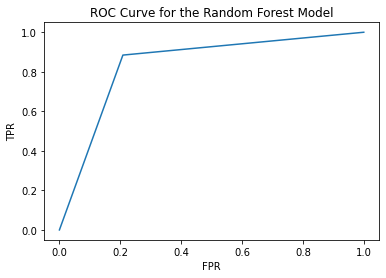

In [34]:
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve for the Random Forest Model')
plt.plot(rf_fpr, rf_tpr)

# Confidence Interval Visualization for Tuned Random Forest

In [35]:
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

In [36]:
train_accuracy = []
test_accuracy = []
for i in np.arange(100):
    #print(i)
    rf_model = RandomForestClassifier(n_estimators = rf_best_params['n_estimators'], 
                                      min_samples_split = rf_best_params['min_samples_split'], 
                                      min_samples_leaf = rf_best_params['min_samples_leaf'], 
                                      max_features = rf_best_params['max_features'], 
                                      max_depth = rf_best_params['max_depth'], 
                                      bootstrap = rf_best_params['bootstrap'],
                                      random_state = 42,
                                      n_jobs = 1
                                     )
    
    sample = pitching.sample(int(0.8 * len(pitching)))
    s_train, s_test = train_test_split(sample)

    s_X = s_train.drop(columns = ['playerID', 'yearID', 'teamID', 'is_all_star'])
    s_y = s_train['is_all_star']
    b_fitted = rf_model.fit(s_X, s_y)
    rf_predictions_test = b_fitted.predict(s_test.drop(columns = ['playerID', 'yearID', 'teamID', 'is_all_star']))
    rf_predictions_train = fitted.predict(s_X)
    train_accuracy = np.append(train_accuracy, np.mean(s_train['is_all_star'].values == rf_predictions_train))
    test_accuracy = np.append(test_accuracy, np.mean(s_test['is_all_star'].values == rf_predictions_test))

mean_confidence_interval_train = mean_confidence_interval(train_accuracy)
mean_confidence_interval_test = mean_confidence_interval(test_accuracy)

(array([ 2.,  0.,  3., 12., 14., 20., 26.,  6., 13.,  4.]),
 array([0.89952153, 0.90248804, 0.90545455, 0.90842105, 0.91138756,
        0.91435407, 0.91732057, 0.92028708, 0.92325359, 0.9262201 ,
        0.9291866 ]),
 <a list of 10 Patch objects>)

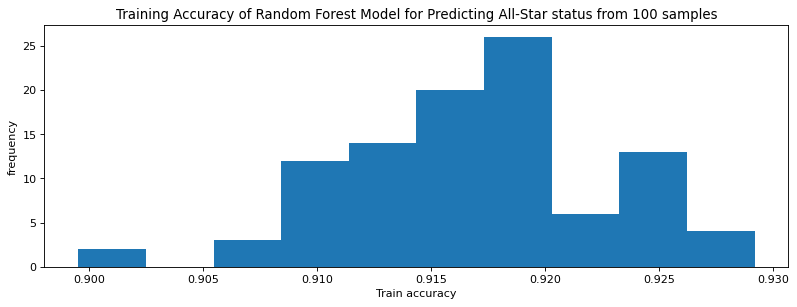

In [37]:
figure(figsize=(12, 4), dpi=80)
plt.xlabel('Train accuracy')
plt.ylabel('frequency')
plt.title('Training Accuracy of Random Forest Model for Predicting All-Star status from 100 samples')
plt.hist(train_accuracy)

(array([ 3.,  8., 10., 13., 20., 14., 12.,  7., 12.,  1.]),
 array([0.81948424, 0.8269341 , 0.83438395, 0.84183381, 0.84928367,
        0.85673352, 0.86418338, 0.87163324, 0.87908309, 0.88653295,
        0.89398281]),
 <a list of 10 Patch objects>)

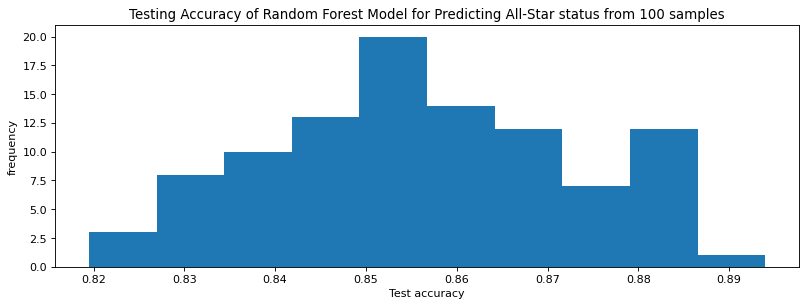

In [38]:
figure(figsize=(12, 4), dpi=80)
plt.xlabel('Test accuracy')
plt.ylabel('frequency')
plt.title('Testing Accuracy of Random Forest Model for Predicting All-Star status from 100 samples')
plt.hist(test_accuracy)

# Random Search Optimization for Tuned Logistic Regression

In [39]:
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]

random_grid = {'solver': solvers,
               'penalty': penalty,
               'C': c_values,
               'max_iter': [2000],
               'random_state': [42],
               'n_jobs': [1]
               }

In [40]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
lr = LogisticRegression()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
lr_random = RandomizedSearchCV(estimator = lr, param_distributions = random_grid, n_iter = 30, cv = 3, verbose=2, random_state=42, n_jobs = 1)
# Fit the random search model
lr_random.fit(X_train, y_train)

Fitting 3 folds for each of 15 candidates, totalling 45 fits
[CV] solver=newton-cg, random_state=42, penalty=l2, n_jobs=1, max_iter=2000, C=100 
[CV]  solver=newton-cg, random_state=42, penalty=l2, n_jobs=1, max_iter=2000, C=100, total=   0.0s
[CV] solver=newton-cg, random_state=42, penalty=l2, n_jobs=1, max_iter=2000, C=100 
[CV]  solver=newton-cg, random_state=42, penalty=l2, n_jobs=1, max_iter=2000, C=100, total=   0.0s
[CV] solver=newton-cg, random_state=42, penalty=l2, n_jobs=1, max_iter=2000, C=100 
[CV]  solver=newton-cg, random_state=42, penalty=l2, n_jobs=1, max_iter=2000, C=100, total=   0.0s
[CV] solver=lbfgs, random_state=42, penalty=l2, n_jobs=1, max_iter=2000, C=100 
[CV]  solver=lbfgs, random_state=42, penalty=l2, n_jobs=1, max_iter=2000, C=100, total=   0.1s
[CV] solver=lbfgs, random_state=42, penalty=l2, n_jobs=1, max_iter=2000, C=100 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV]  solver=lbfgs, random_state=42, penalty=l2, n_jobs=1, max_iter=2000, C=100, total=   0.2s
[CV] solver=lbfgs, random_state=42, penalty=l2, n_jobs=1, max_iter=2000, C=100 
[CV]  solver=lbfgs, random_state=42, penalty=l2, n_jobs=1, max_iter=2000, C=100, total=   0.1s
[CV] solver=liblinear, random_state=42, penalty=l2, n_jobs=1, max_iter=2000, C=100 
[CV]  solver=liblinear, random_state=42, penalty=l2, n_jobs=1, max_iter=2000, C=100, total=   0.0s
[CV] solver=liblinear, random_state=42, penalty=l2, n_jobs=1, max_iter=2000, C=100 
[CV]  solver=liblinear, random_state=42, penalty=l2, n_jobs=1, max_iter=2000, C=100, total=   0.0s
[CV] solver=liblinear, random_state=42, penalty=l2, n_jobs=1, max_iter=2000, C=100 
[CV]  solver=liblinear, random_state=42, penalty=l2, n_jobs=1, max_iter=2000, C=100, total=   0.0s
[CV] solver=newton-cg, random_state=42, penalty=l2, n_jobs=1, max_iter=2000, C=10 
[CV]  solver=newton-cg, random_state=42, penalty=l2, n_jobs=1, max_iter=2000, C=10, total=   0.0s


[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:    2.2s finished


RandomizedSearchCV(cv=3, estimator=LogisticRegression(), n_iter=30, n_jobs=1,
                   param_distributions={'C': [100, 10, 1.0, 0.1, 0.01],
                                        'max_iter': [2000], 'n_jobs': [1],
                                        'penalty': ['l2'], 'random_state': [42],
                                        'solver': ['newton-cg', 'lbfgs',
                                                   'liblinear']},
                   random_state=42, verbose=2)

In [41]:
lr_best_params = lr_random.best_params_
lr_best_params

{'solver': 'liblinear',
 'random_state': 42,
 'penalty': 'l2',
 'n_jobs': 1,
 'max_iter': 2000,
 'C': 1.0}

# Logistic Regression Model Training with Tuned Hyperparameters

In [42]:
lr_model = LogisticRegression(solver = lr_best_params['solver'], 
                              penalty = lr_best_params['penalty'], 
                              max_iter = lr_best_params['max_iter'], 
                              C = lr_best_params['C'],
                              random_state = 42,
                              n_jobs = 1
                             )

fitted = lr_model.fit(X_train, y_train)
lr_predictions_test = fitted.predict(X_test)
lr_predictions_train = fitted.predict(X_train)

In [43]:
print('training accuracy for logistic regression: ')
np.mean(y_train == lr_predictions_train)

training accuracy for logistic regression: 


0.854628921193573

In [44]:
print('test accuracy for logistic regression: ')
np.mean(y_test == lr_predictions_test)

test accuracy for logistic regression: 


0.8486238532110092

# Validation for Tuned Logistic Regression Model

In [45]:
confusion_matrix_lr = metrics.confusion_matrix(y_test, lr_predictions_test, normalize = 'all')
precision_lr = confusion_matrix_lr[1][1] / (confusion_matrix_lr[1][1] + confusion_matrix_lr[0][1])
recall_lr = confusion_matrix_lr[1][1] / (confusion_matrix_lr[1][1] + confusion_matrix_lr[1][0])
print('precision: ' + str(precision_lr))
print('recall: ' + str(recall_lr))

precision: 0.8354430379746836
recall: 0.8800000000000001


In [46]:
lr_fpr, lr_tpr, lr_thresholds = metrics.roc_curve(y_test, lr_predictions_test)
lr_fpr, lr_tpr, lr_thresholds

(array([0.        , 0.18483412, 1.        ]),
 array([0.  , 0.88, 1.  ]),
 array([2, 1, 0]))

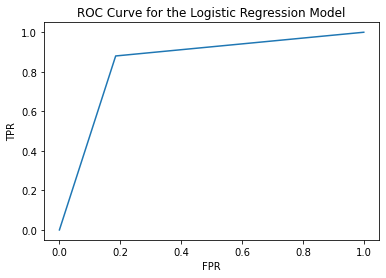

In [47]:
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve for the Logistic Regression Model')
plt.plot(lr_fpr, lr_tpr)

# Confidence Interval Visualization for Tuned Logistic Regression

In [48]:
train_accuracy = []
test_accuracy = []
for i in np.arange(100):
    #print(i)
    lr_model = LogisticRegression(solver = lr_best_params['solver'], 
                                  penalty = lr_best_params['penalty'], 
                                  max_iter = lr_best_params['max_iter'], 
                                  C = lr_best_params['C'],
                                  random_state = 42,
                                  n_jobs = 1
                                 )
    
    sample = pitching.sample(int(0.8 * len(pitching)))
    s_train, s_test = train_test_split(sample)

    s_X = s_train.drop(columns = ['playerID', 'yearID', 'teamID', 'is_all_star'])
    s_y = s_train['is_all_star']
    b_fitted = rf_model.fit(s_X, s_y)
    lr_predictions_test = b_fitted.predict(s_test.drop(columns = ['playerID', 'yearID', 'teamID', 'is_all_star']))
    lr_predictions_train = fitted.predict(s_X)
    train_accuracy = np.append(train_accuracy, np.mean(s_train['is_all_star'].values == lr_predictions_train))
    test_accuracy = np.append(test_accuracy, np.mean(s_test['is_all_star'].values == lr_predictions_test))

mean_confidence_interval_train = mean_confidence_interval(train_accuracy)
mean_confidence_interval_test = mean_confidence_interval(test_accuracy)

(array([ 4.,  4.,  5., 16., 15., 22., 17., 10.,  5.,  2.]),
 array([0.8354067 , 0.83885167, 0.84229665, 0.84574163, 0.8491866 ,
        0.85263158, 0.85607656, 0.85952153, 0.86296651, 0.86641148,
        0.86985646]),
 <a list of 10 Patch objects>)

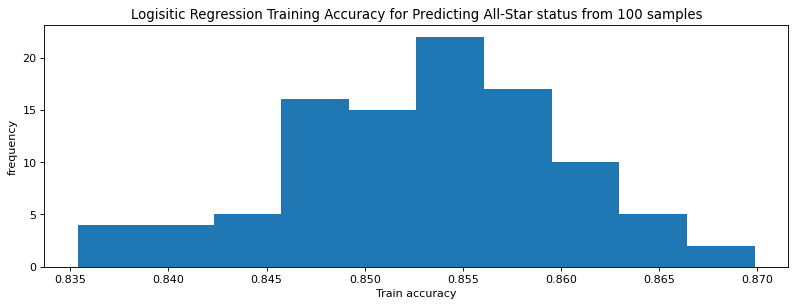

In [49]:
figure(figsize=(12, 4), dpi=80)
plt.xlabel('Train accuracy')
plt.ylabel('frequency')
plt.title('Logisitic Regression Training Accuracy for Predicting All-Star status from 100 samples')
plt.hist(train_accuracy)

(array([ 4., 10., 17., 14., 20., 17., 10.,  6.,  1.,  1.]),
 array([0.82234957, 0.83094556, 0.83954155, 0.84813754, 0.85673352,
        0.86532951, 0.8739255 , 0.88252149, 0.89111748, 0.89971347,
        0.90830946]),
 <a list of 10 Patch objects>)

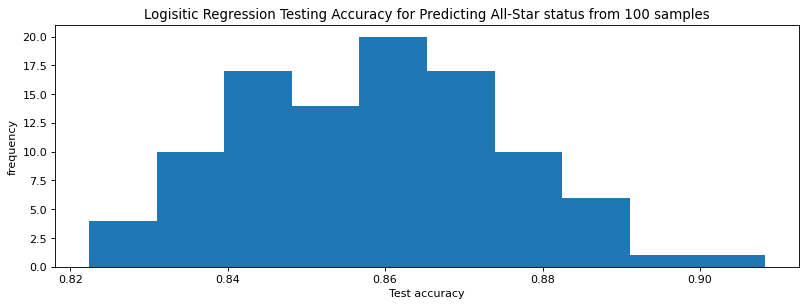

In [50]:
figure(figsize=(12, 4), dpi=80)
plt.xlabel('Test accuracy')
plt.ylabel('frequency')
plt.title('Logisitic Regression Testing Accuracy for Predicting All-Star status from 100 samples')
plt.hist(test_accuracy)

# Uncertainty Interval for Logistic Regression (GLM) Testing Accuracy

In [51]:
logistic_regression_sample_accuracies = dict()
logistic_regression_sample_accuracies['min_test_acc'] = min(test_accuracy)
logistic_regression_sample_accuracies['avg_test_acc'] = np.mean(test_accuracy)
logistic_regression_sample_accuracies['max_test_acc'] = max(test_accuracy)

In [52]:
logistic_regression_sample_accuracies

{'min_test_acc': 0.8223495702005731,
 'avg_test_acc': 0.8568481375358167,
 'max_test_acc': 0.9083094555873925}

In [56]:
percentile_95 = np.mean(test_accuracy) + 2 * test_accuracy.std()
percentile_95

0.890847128642818

In [57]:
percentile_05 = np.mean(test_accuracy) - 2 * test_accuracy.std()
percentile_05

0.8228491464288153